## Viheicle detection:

Loading necessary libararies:

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

Reading the imge file paths:

In [2]:
#cars = glob.glob('vehicles_smallset/*/*/*.jpeg')
#notcars = glob.glob('non-vehicles_smallset/*/*/*.jpeg')
cars = glob.glob('vehicles/*/*/*.png')
notcars = glob.glob('non-vehicles/*/*/*.png')

Visualizing a car image and its HOG image:

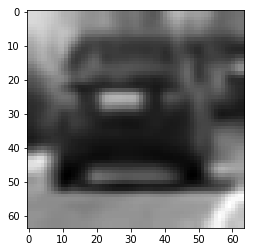

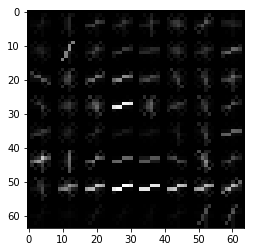

In [3]:

orient = 9
pix_per_cell = 8
cell_per_block = 2

img = mpimg.imread(cars[0])
img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
features, hog_image = hog(img[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                          cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                          visualise=True, feature_vector=True)
plt.imshow(img[:,:,1],cmap='gray')
plt.show()
plt.imshow(hog_image,cmap='gray')
plt.show()

Defining the functions:

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(img, conv):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'LUV':
         return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), cspace_hog = 'RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            feature_image = convert_color(image, cspace)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        if cspace_hog != 'RGB':
            feature_image = convert_color(image, cspace_hog)
        else: feature_image = np.copy(image) 
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return features

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


Train the linear SVM classifier:

In [5]:
spatial = 16
histbin = 16
colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
colorspace_hog= 'LUV'
orient = 10
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

car_features = extract_features(cars, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), cspace_hog= colorspace_hog, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), cspace_hog= colorspace_hog, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=2)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
#svc = SVC(C=1000,kernel='rbf')
#svc =RandomForestClassifier(n_estimators=100)
#svc = DecisionTreeClassifier(max_depth=100)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

('Using spatial binning of:', 16, 'and', 16, 'histogram bins')
('Feature vector length:', 2776)
(7.76, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9848)
('My SVC predicts: ', array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.]))
('For these', 10, 'labels: ', array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.]))
(0.002, 'Seconds to predict', 10, 'labels with SVC')


Define the search_windows and test it on an input image:

Wall time: 993 ms


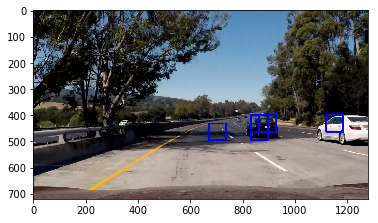

In [28]:
def search_windows(img, windows, clf, scaler, cspace='RGB', cspace_hog='HSV',
                   spatial_size=(spatial, spatial), hist_bins=32, 
                   hist_range=(0, 256), orient=8, 
                   pix_per_cell=8, cell_per_block=2,hog_channel=0):
    
    if cspace_hog != 'RGB':
        Im = convert_color(img, cspace_hog)
    else:
        Im = img
    hog2 = get_hog_features(Im[:,:,2], orient, pix_per_cell, cell_per_block, feature_vec=False)
    if cspace != 'RGB':
        Im = convert_color(img, cspace)
    else:
        Im = img
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        if cspace_hog != 'RGB':
            Im = convert_color(test_img, cspace_hog)
        else:
            Im=test_img
        hog_features = get_hog_features(Im[:,:,hog_channel], orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
        if cspace != 'RGB':
            Im = convert_color(test_img, cspace)
        else:
            Im = test_img  
        spatial_features = bin_spatial(Im, size=spatial_size)
        hist_features = color_hist(Im, nbins=hist_bins)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

y_start_stop = [400, 650] 
spatial_size = (spatial, spatial)

image = mpimg.imread('test_images/test5.jpg')
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,\
                       xy_window=(64, 64), xy_overlap=(0.5, 0.5))

%time hot_windows = search_windows(image, windows, svc, X_scaler, cspace=colorspace, cspace_hog=colorspace_hog,\
                                   spatial_size=spatial_size, hist_bins=histbin,\
                                   orient=orient, pix_per_cell=pix_per_cell,\
                                   cell_per_block=cell_per_block,hog_channel=0)                       

window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()

Defining sub-sampling windsow search. Use this function to serch inside the area found by the search_windows function:

Wall time: 78 ms


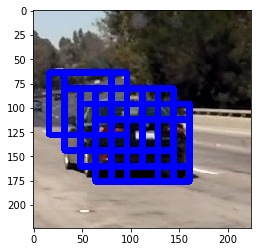

In [32]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,\
             cspace='RGB', cspace_hog='HSV'):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if cspace_hog != 'RGB':
        ctrans_tosearch = convert_color(img_tosearch, cspace_hog)
    else:
        ctrans_tosearch = img_tosearch
        
    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    #ch2 = ctrans_tosearch[:,:,1]
    #ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    if cspace != 'RGB':
        ctrans_tosearch = convert_color(img_tosearch, cspace)
    else:
        ctrans_tosearch = img_tosearch
    box_list=[]   
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, box_list
    
ystart = int(420)
ystop = int(600)
scale = 1
spatial_size = (spatial, spatial)


colorspace_hog='LUV'
colorspace='LUV'

image = mpimg.imread('test_images/test1.jpg')
#image = cv2.resize(image,(int(image.shape[1]/2),int(image.shape[0]/2)))
window=hot_windows[1]
Im=image[window[0][1]-80:window[1][1]+80,window[0][0]-80:window[1][0]+80]

% time out_img,box_list = find_cars(Im, 0, Im.shape[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, histbin,\
                   cspace=colorspace, cspace_hog=colorspace_hog)

plt.imshow(out_img)
plt.show()

Transfer the coordinates of the detected boxes to the main image size:

In [33]:
box_list = zip(zip(list(np.array(box_list)[:,0,0]+window[0][0]),list(np.array(box_list)[:,0,1]+window[0][1])),\
                               zip(list(np.array(box_list)[:,1,0]+window[0][0]),list(np.array(box_list)[:,1,1]+window[0][1])))


Plotting the heat map of detected sub_sampling winodws from one of the sliding windows as above:

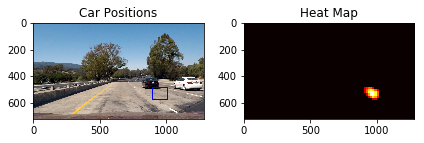

In [35]:
from scipy.ndimage.measurements import label

heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if (bbox[1][0]-bbox[0][0])>20 and (bbox[1][1]-bbox[0][1])>20:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

Define the pipleline function to process the frames foir video:

In [18]:
def pipeline(img):
    #img = cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0]/2)))
    _, box_list1 = find_cars(img, ystart, ystop, 0.95, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, histbin,\
                   cspace=colorspace, cspace_hog=colorspace_hog)
    _, box_list = find_cars(img, ystart, ystop, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, histbin,\
                   cspace=colorspace, cspace_hog=colorspace_hog)
    if len(box_list1)>0 and len(box_list)>0:
        box_list.extend(box_list1)
    if len(box_list)>0:
        box_list = zip(zip(list(np.array(box_list)[:,0,0]-20),list(np.array(box_list)[:,0,1]-20)),\
                       zip(list(np.array(box_list)[:,1,0]+20),list(np.array(box_list)[:,1,1]+20)))
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    heat = apply_threshold(heat,12)   
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(img, labels)
    return draw_img

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,\
                       xy_window=(64, 64), xy_overlap=(0.75, 0.75))
windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,\
                       xy_window=(100, 100), xy_overlap=(0.75, 0.75)))
windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,\
                       xy_window=(120, 120), xy_overlap=(0.75, 0.75)))

def pipeline2(img):
    #img = cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0]/2)))
    hot_windows = search_windows(img, windows, svc, X_scaler, cspace=colorspace, cspace_hog=colorspace_hog,\
                                 spatial_size=spatial_size, hist_bins=histbin,\
                                 orient=orient, pix_per_cell=pix_per_cell,\
                                 cell_per_block=cell_per_block,hog_channel=0)                       
    global box
    if len(hot_windows)>0:
        for window in hot_windows:
            Im=image[window[0][1]-20:window[1][1]+20,window[0][0]-20:window[1][0]+20]
            _, box_list = find_cars(Im, 0, Im.shape[1], 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, histbin,\
                                    cspace=colorspace, cspace_hog=colorspace_hog)
            if len(box_list)>0:
                box_list = zip(zip(list(np.array(box_list)[:,0,0]+window[0][0]),list(np.array(box_list)[:,0,1]+window[0][1])),\
                               zip(list(np.array(box_list)[:,1,0]+window[0][0]),list(np.array(box_list)[:,1,1]+window[0][1])))
            box.extend(box_list)
    box = box[-5:]
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box)
    heat = apply_threshold(heat,7)   
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(img, labels)
    return draw_img

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
box = []

clip1 = VideoFileClip("project_video.mp4").subclip()
white_clip = clip1.fl_image(pipeline2) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)